In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Hotel_Reviews.csv



# **About the Dataset**
The data was scraped from **Booking.com**. All data in the file is publicly available to everyone already. Data is originally owned by **Booking.com**.

In [31]:
#loading the dataset from the Hotel_reviews dataset
df = pd.read_csv("../input/Hotel_Reviews.csv")

# **Data Analysis**

In [32]:
#printing the columns names of the datset
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [33]:
#printing the shape of the dataset
df.shape

(515738, 17)

In [34]:
# seeing the no of unique hotels through 'Hotel_name' attribute 
uniq_no_hotels = set(df['Hotel_Name'])
print(len(uniq_no_hotels))

1492


This dataset contains **515,000  customer reviews** and scoring of **1493  Luxury Hotels** across Europe.

The csv file contains 17 fields. The description of each field is as below:

* **Hotel_Address**: Address of hotel.
* **Review_Date**: Date when reviewer posted the corresponding review.
* **Average_Score**: Average Score of the hotel, calculated based on the latest comment in the last year.
* **Hotel_Name**: Name of Hotel
* **Reviewer_Nationality**: Nationality of Reviewer
* **Negative_Review**: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
* **Review_Total_Negative_Word_Counts**: Total number of words in the negative review.
* **Positive_Review**: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
* **Review_Total_Positive_Word_Counts**: Total number of words in the positive review.
* **Reviewer_Score**: Score the reviewer has given to the hotel, based on his/her experience
* **Total_Number_of_Reviews_Reviewer_Has_Given**: Number of Reviews the reviewers has given in the past.
* **Total_Number_of_Reviews**: Total number of valid reviews the hotel has.
* **Tags**: Tags reviewer gave the hotel.
* **days_since_review**: Duration between the review date and scrape date.
* **Additional_Number_of_Scoring**: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
* **lat**: Latitude of the hotel
* **lng**: longtitude of the hotel


Meanwhile, the geographical location of hotels are also provided for further analysis.

### Checking whether there are any missing values in the dataset.

In [35]:
import missingno as msno

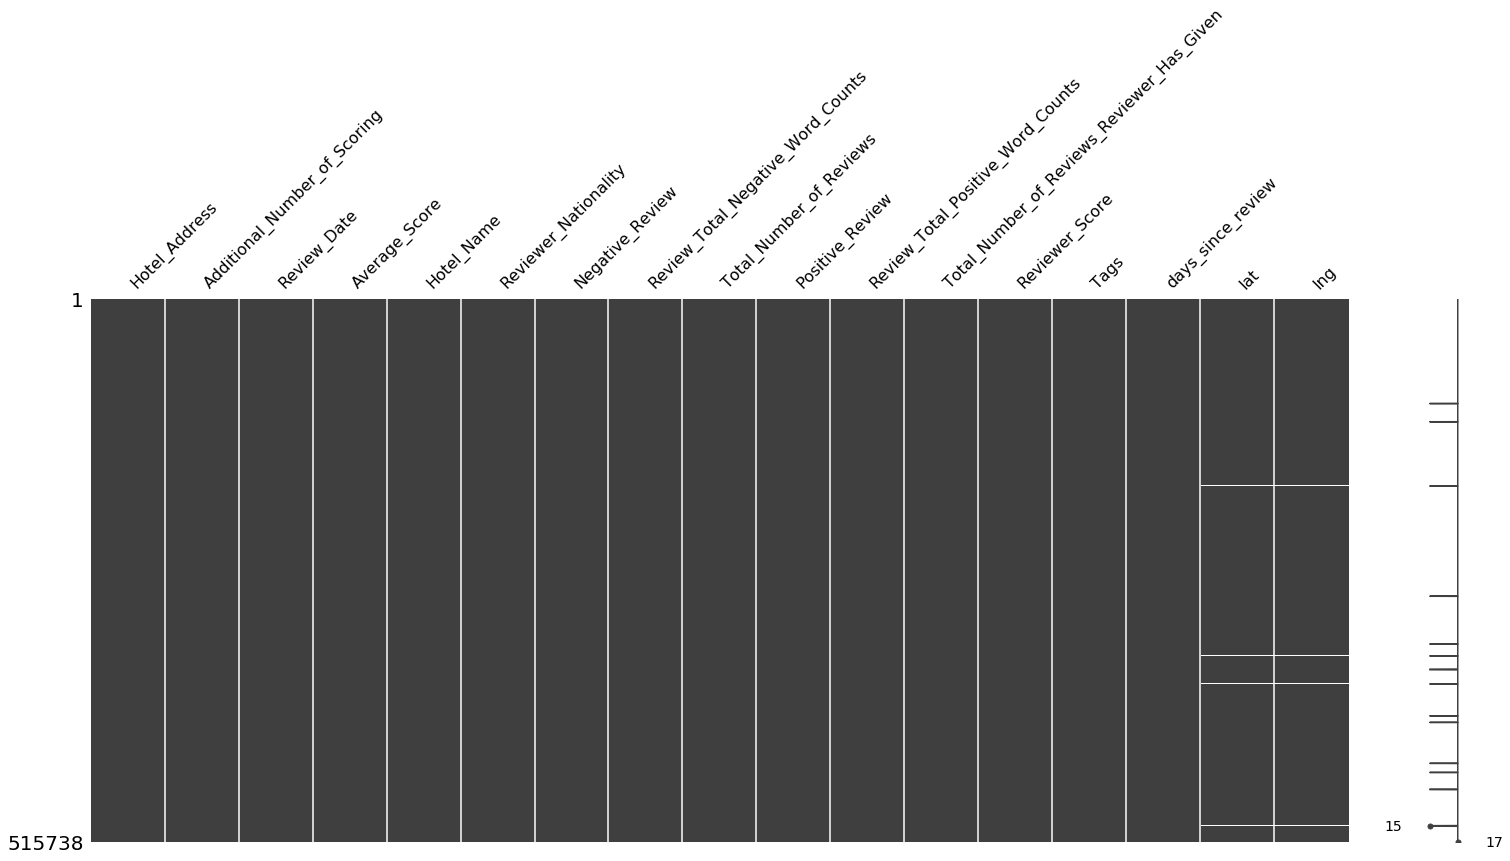

In [36]:
msno.matrix(df)

*  ### From the above plot we can see there are some missing values in  **lat**(Latitude) and **lng**(Longitude) attributes in the dataset. 
* ### Lets look at the missing values in the dataset.

In [37]:
nans = lambda df: df[df.isnull().any(axis=1)]

nans_df = nans(df)

In [38]:
nans_df

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
99488,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No Negative,0,377,Upgraded rooms are excellent Good size for tr...,25,6,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99489,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Noise Not being told about this when we check...,12,377,The location was great However renovations we...,45,1,6.7,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99490,20 Rue De La Ga t 14th arr 75014 Paris France,22,7/25/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,Room was worn down One of the curtains did no...,43,377,Location was good,5,1,5.4,"[' Leisure trip ', ' Solo traveler ', ' Standa...",9 days,NaN,NaN
99491,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,8.3,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,NaN,NaN
99492,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/24/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,The breakfast was way over priced and the sta...,83,377,The property was conveniently located near th...,11,2,5.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",71 days,NaN,NaN
99493,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/5/2017,7.8,Mercure Paris Gare Montparnasse,Belgium,Work in progress noise no bar keys had to be ...,39,377,Comfort,2,3,5.0,"[' Leisure trip ', ' Family with young childre...",90 days,NaN,NaN
99494,20 Rue De La Ga t 14th arr 75014 Paris France,22,2/11/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Max price for the bare minimum Acor Hotels ca...,67,377,Few minutes walk to Ga t Metro Montparnasse M...,46,20,5.8,"[' Business trip ', ' Couple ', ' Standard Roo...",173 day,NaN,NaN
99495,20 Rue De La Ga t 14th arr 75014 Paris France,22,12/5/2016,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Ongoing refurbishment whilst we were there,8,377,Very quiet at night couldn t believe we were ...,21,1,8.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",241 day,NaN,NaN
99496,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/30/2016,7.8,Mercure Paris Gare Montparnasse,France,We took a room for 3 the extra bed couch bed ...,23,377,Great location 5 min away from gare montparna...,32,34,8.3,"[' Leisure trip ', ' Family with young childre...",277 day,NaN,NaN
99497,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/11/2016,7.8,Mercure Paris Gare Montparnasse,United States of America,N A Room lacking microwave a minor inconvenie...,10,377,Great neighborhood with lots of restaurants s...,22,1,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",296 day,NaN,NaN


In [44]:
nans_df = nans_df[['lat','lng']]

In [45]:
nans_df

,lat,lng
99488,NaN,NaN
99489,NaN,NaN
99490,NaN,NaN
99491,NaN,NaN
99492,NaN,NaN
99493,NaN,NaN
99494,NaN,NaN
99495,NaN,NaN
99496,NaN,NaN
99497,NaN,NaN


* We see that there are about **3268  Nan** (missing values) in the dataset.

* Instead of removing the **Nan** values from the dataset,
Try to fill the **Nan** values with the similar **Hotel_Addresses *lat, lng* values**  in the dataset. 
If the **Hotel_Address** is matched with the other rows(i.e **Nan** valued rows) in the dataset, Fill the **Nan** values in the dataset with the matched values(i.e., **lat**,**lng**).

In [47]:
df = df.fillna(method = 'ffill').fillna(method = 'bfill')

In [54]:
nans = lambda df: df[df.isnull().any(axis=1)]

nans_df = nans(df)

nans_df.shape

(0, 17)

**Now all the missing are filled in the dataset.**

In [55]:
#checking whether the data is filled or not
temp_df = df[['lat','lng']]
temp_df.iloc[99492:99515]

,lat,lng
99492,48.847346,2.283241
99493,48.847346,2.283241
99494,48.847346,2.283241
99495,48.847346,2.283241
99496,48.847346,2.283241
99497,48.847346,2.283241
99498,48.847346,2.283241
99499,48.847346,2.283241
99500,48.847346,2.283241
99501,48.847346,2.283241
